<a href="https://colab.research.google.com/github/jeanbai/Human-Protein-Cell-Classification/blob/main/Human_Protein_Cell_Transfer_Learning_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Transfer Learning


With transfer learning, we take a pre-trained model and retrain it on a task that has some overlap with the original training task. A good analogy for this is an artist who is skilled in one medium, such as painting, who wants to learn to practice in another medium, such as charcoal drawing. We can imagine that the skills they learned while painting would be very valuable in learning how to draw with charcoal.

As an example in deep learning, say we have a pre-trained model that is very good at recognizing different types of cars, and we want to train a model to recognize types of motorcycles. A lot of the learnings of the car model would likely be very useful, for instance the ability to recognize headlights and wheels.

Transfer learning is especially powerful when we do not have a large and varied dataset. In this case, a model trained from scratch would likely memorize the training data quickly, but not be able to generalize well to new data. With transfer learning, you can increase your chances of training an accurate and robust model on a small dataset.



## download the pre_trained model

Downloading the Pretrained Model
The ImageNet pre-trained models are often good choices for computer vision transfer learning, as they have learned to classify various different types of images. In doing this, they have learned to detect many different types of features that could be valuable in image recognition. 



In [ ]:
from tensorflow import keras

base_model = keras.applications.VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False)

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Freezing the Base Model

Before adding the new layers onto the pre-trained model, we should take an important step: freezing the model's pre-trained layers. This means that when we train, we will not update the base layers from the pre-trained model. Instead we will only update the new layers that we add on the end for our new classification. We freeze the initial layers because we want to retain the learning achieved from training on the ImageNet dataset. If they were unfrozen at this stage, we would likely destroy this valuable information. There will be an option to unfreeze and train these layers later, in a process called fine-tuning.

Freezing the base layers is as simple as setting trainable on the model to False.

In [ ]:
base_model.trainable = False

##Adding New Layers
We can now add the new trainable layers to the pre-trained model. They will take the features from the pre-trained layers and turn them into predictions on the new dataset. We will add two layers to the model. First add the layer of input layer with same shape of the image.We then need to add our the layer, which will classify the 19 labels in each image. This will be a densely connected layer with one output.

In [ ]:
inputs = keras.Input(shape=(224, 224, 3))
# Separately from setting trainable on the model, we set training to False 
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(19)(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 19)                9747      
Total params: 14,724,435
Trainable params: 9,747
Non-trainable params: 14,714,688
_________________________________________________________________


Keras gives us a nice summary here, as it shows the vgg16 pre-trained model as one unit, rather than showing all of the internal layers. It is also worth noting that we have many non-trainable parameters as we have frozen the pre-trained model.

## Loading the Data




In [ ]:
import math, re, os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from tqdm import tqdm

Import label dataset

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/train.csv")

In [ ]:
data.head()

,ID,Label
0,5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0,8|5|0
1,5fb643ee-bb99-11e8-b2b9-ac1f6b6435d0,14|0
2,60b57878-bb99-11e8-b2b9-ac1f6b6435d0,6|1
3,5c1a898e-bb99-11e8-b2b9-ac1f6b6435d0,16|10
4,5b931256-bb99-11e8-b2b9-ac1f6b6435d0,14|0


In [ ]:
label_names = {
    '0': "Nucleoplasm",
    '1': "Nuclear membrane",
    '2': "Nucleoli",
    '3': "Nucleoli fibrillar center",
    '4': "Nuclear speckles",
    '5': "Nuclear bodies",
    '6': "Endoplasmic reticulum",
    '7': "Golgi apparatus",
    '8': "Intermediate filaments",
    '9': "Actin filaments",
    '10': "Microtubules",
    '11': "Mitotic spindle",
    '12': "Centrosome",
    '13': "Plasma membrane",
    '14': "Mitochondria",
    '15': "Aggresome",
    '16': "Cytosol",
    '17': "Vesicles and punctate cytosolic patterns",
    '18': "Negative",
}

Apply Hot_Encode for multi_label categories

In [ ]:
train = data.copy()
lab_idx = label_names.keys()

train['Label'] = train['Label'].map(lambda x: x.split('|'))

for label in lab_idx:
    train[label_names[label]] = train['Label'].map(lambda result: 1 if label in result else 0)

In [ ]:
train.head()

,ID,Label,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,Endoplasmic reticulum,Golgi apparatus,Intermediate filaments,Actin filaments,Microtubules,Mitotic spindle,Centrosome,Plasma membrane,Mitochondria,Aggresome,Cytosol,Vesicles and punctate cytosolic patterns,Negative
0,5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0,"[8, 5, 0]",1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
1,5fb643ee-bb99-11e8-b2b9-ac1f6b6435d0,"[14, 0]",1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,60b57878-bb99-11e8-b2b9-ac1f6b6435d0,"[6, 1]",0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,5c1a898e-bb99-11e8-b2b9-ac1f6b6435d0,"[16, 10]",0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
4,5b931256-bb99-11e8-b2b9-ac1f6b6435d0,"[14, 0]",1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [ ]:
train.shape

(21806, 21)

Import image file, and preparing the images for prediction

In [ ]:
from tensorflow.keras.preprocessing import image

In [ ]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

from matplotlib import pyplot

In [ ]:

img_width = 224
img_height = 224

X = []

for i in tqdm(range(train.shape[0])):
    path = '/content/drive/MyDrive/rgb/' + train['ID'][i] + '.png'
    img = image.load_img(path, target_size=(img_width, img_height, 3))
    img = image.img_to_array(img)
    img = img/255.0
    X.append(img)

X = np.array(X)


Streaming output truncated to the last 5000 lines.
100%|██████████| 21806/21806 [1:21:51<00:00,  4.44it/s]


In [ ]:
X.shape

(21806, 224, 224, 3)

In [ ]:
y = train.drop(['ID',"Label"],axis = 1)
y = y.to_numpy()
y.shape

(21806, 19)

Create Train file and valid file

In [ ]:
X_train, X_valid,y_train,y_valid = train_test_split(X, y, test_size = 0.30)

In [ ]:
X_train.shape

In [ ]:
X_valid.shape

(6542, 224, 224, 3)

##Augmenting the Data
Now that we are dealing with a very imbalanced dataset, it is especially important that we augment our data. We will make small modifications to the existing images, which will allow the model to see a wider variety of images to learn from. Moreover the original image is kind of dark, so that make the image a litter brighter will help the training process.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# create a data generator
datagen = ImageDataGenerator(
        samplewise_center=True,  # set each sample mean to 0
        
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True, 
        brightness_range=[0.3,1.0],
        )

Batch_size

Another benefit of the ImageDataGenerator is that it batches our data so that our model can train on a random sample.
If the model is truly random, meaning that the data is properly shuffled so it's fair like a deck of cards, then our sample can do a good job of representing all of our data even though it is a tiny fraction of the population. For each step of the training, the model will be dealt a new batch.
In practice, a batch size of 32 and 64 does well. Run the cell below to see what kind of batches we'll be training our model with. Is our randomizer fairly randomizing? Are all of the images recognizable ASL letters?

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

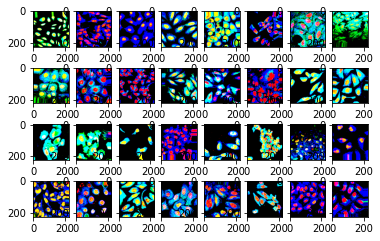

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
batch_size = 32
img_iter = datagen.flow(X_train, y_train, batch_size=batch_size)

x, y = img_iter.next()
fig, ax = plt.subplots(nrows=4, ncols=8)
for i in range(batch_size):
    image = x[i]
    ax.flatten()[i].imshow(np.squeeze(image))
plt.show()

### Fit the Data to the Generator

In [ ]:
datagen.fit(X_train)

##Compiling the Model
As with the previous exercises, we need to compile the model with loss and metrics options. In this case we only have a binary classification problem (), and so we will use binary crossentropy. We will also use binary accuracy instead of traditional accuracy.

By setting from_logits=True we inform the loss function that the output values are not normalized (e.g. with softmax).

In [ ]:
# Important to use binary crossentropy and binary accuracy as we now have a binary classification problem
model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True), metrics=[keras.metrics.BinaryAccuracy()])

##Training the Model
Time to train our model and see how it does. Recall that when using a data generator, we have to explicitly set the number of steps_per_epoch:

In [ ]:
model.fit(img_iter,
          epochs=5,
          steps_per_epoch=len(X_train)/batch_size, # Run same number of steps we would if we were not using a generator.
          validation_data=(X_valid, y_valid))

Epoch 1/5
477/477 [==============================] - 699s 1s/step - loss: 0.3524 - binary_accuracy: 0.8969 - val_loss: 0.3025 - val_binary_accuracy: 0.9137
Epoch 2/5
477/477 [==============================] - 706s 1s/step - loss: 0.2491 - binary_accuracy: 0.9187 - val_loss: 0.2669 - val_binary_accuracy: 0.9137
Epoch 3/5
477/477 [==============================] - 705s 1s/step - loss: 0.2394 - binary_accuracy: 0.9195 - val_loss: 0.2585 - val_binary_accuracy: 0.9137
Epoch 4/5
477/477 [==============================] - 705s 1s/step - loss: 0.2342 - binary_accuracy: 0.9203 - val_loss: 0.2544 - val_binary_accuracy: 0.9137
Epoch 5/5
477/477 [==============================] - 699s 1s/step - loss: 0.2312 - binary_accuracy: 0.9214 - val_loss: 0.2528 - val_binary_accuracy: 0.9137


##Discussion of Results
Both the training and validation accuracy should be quite high. This is a pretty awesome result! However the valid accuracy remains at the same result.  Because of the knowledge transferred from the ImageNet model, it was able to achieve high accuracy and generalize well. 


##Fine-Tuning the Model
Now that the new layers of the model are trained, we have the option to apply a final trick to improve the model, called fine-tuning. To do this we unfreeze the entire model, and train it again with a very small learning rate. This will cause the base pre-trained layers to take very small steps and adjust slightly, improving the model by a small amount.

Note that it is important to only do this step after the model with frozen layers has been fully trained. The untrained pooling and classification layers that we added to the model earlier were randomly initialized. This means they needed to be updated quite a lot to correctly classify the images. Through the process of backpropagation, large initial updates in the last layers would have caused potentially large updates in the pre-trained layers as well. These updates would have destroyed those important pre-trained features. However, now that those final layers are trained and have converged, any updates to the model as a whole will be much smaller (especially with a very small learning rate) and will not destroy the features of the earlier layers.

Let's try unfreezing the pre-trained layers, and then fine tuning the model:

In [30]:
# Unfreeze the base model
base_model.trainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are taken into account
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate = .00001),  # Very low learning rate
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

With out set batch_size, let the machine learn every image once a time.

In [31]:
r = model.fit(X_train,y_train,epochs=5,validation_data=(X_valid,y_valid))


Epoch 1/5
477/477 [==============================] - 2810s 6s/step - loss: 0.2242 - binary_accuracy: 0.9191 - val_loss: 0.2002 - val_binary_accuracy: 0.9268
Epoch 2/5
477/477 [==============================] - 2822s 6s/step - loss: 0.1986 - binary_accuracy: 0.9267 - val_loss: 0.1938 - val_binary_accuracy: 0.9300
Epoch 3/5
477/477 [==============================] - 2818s 6s/step - loss: 0.1904 - binary_accuracy: 0.9294 - val_loss: 0.1892 - val_binary_accuracy: 0.9297
Epoch 4/5
477/477 [==============================] - 2830s 6s/step - loss: 0.1823 - binary_accuracy: 0.9314 - val_loss: 0.1820 - val_binary_accuracy: 0.9314
Epoch 5/5
477/477 [==============================] - 2793s 6s/step - loss: 0.1754 - binary_accuracy: 0.9341 - val_loss: 0.1786 - val_binary_accuracy: 0.9339


## Evaluate the Model


In [32]:
evaluation= model.evaluate(X_valid, y_valid)

205/205 [==============================] - 202s 984ms/step - loss: 0.1786 - binary_accuracy: 0.9339


##Examining the Predictions


In [33]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.imagenet_utils import preprocess_input

def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image)

def make_predictions(image_path):
    show_image(image_path)
    image = image_utils.load_img(image_path, target_size=(224, 224))
    image = image_utils.img_to_array(image)
    image = image.reshape(1,224,224,3)
    image = preprocess_input(image)
    preds = model.predict(image)
    return preds

array([[  -9.769555,  -45.727333,   77.44662 ,  133.6634  ,  -96.04017 ,
         -87.57939 ,  -84.89903 , -139.45157 , -221.81671 , -200.00438 ,
        -104.13062 , -337.15723 ,  -63.94531 ,  -14.476755, -206.77444 ,
        -252.81561 ,  219.18593 , -115.702415, -441.05624 ]],
      dtype=float32)

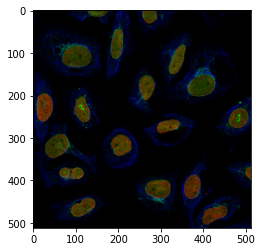

In [34]:
make_predictions('/content/drive/MyDrive/rgb/000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0.png')

In [42]:
print(r.history.keys())

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


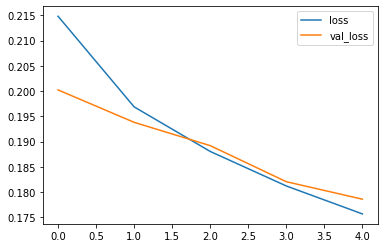

In [43]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

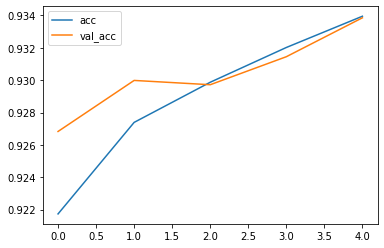

In [44]:
# Plot accuracy per iteration
plt.plot(r.history['binary_accuracy'], label='acc')
plt.plot(r.history['val_binary_accuracy'], label='val_acc')
plt.legend()

In [45]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

  

In [47]:
def plot_learningCurve(history,epoch):
    epoch_range = range(1, epoch+1)
    plt.plot(epoch_range, r.history['binary_accuracy'])
    plt.plot(epoch_range,r.history['val_binary_accuracy'])
    plt.title("Model Accuracy")
    plt.ylabel('accuracy')
    plt.xlabel("Epoch")
    plt.legend(["Train",'Val'], loc='upper left')
    plt.show()

    plt.plot(epoch_range, history.history['loss'])
    plt.plot(epoch_range,history.history['val_loss'])
    plt.title("Model Loss")
    plt.ylabel('Loss')
    plt.xlabel("Epoch")
    plt.legend(["Train",'Val'], loc='upper left')
    plt.show()

In [48]:
import matplotlib.pyplot as plt

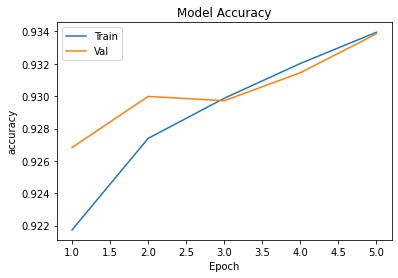

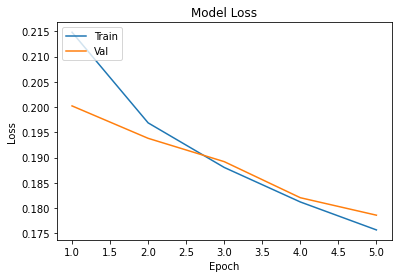

In [50]:
plot_learningCurve(r,5)

In [56]:
Vgg16_Transfer_Model = model

In [57]:
model.save('Vgg16_Transfer_Model')

INFO:tensorflow:Assets written to: Vgg16_Transfer_Model/assets


In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)